# Avaliação da Explicabilidade com GradCAM

In [4]:
# Importações de libraries importantes
import sys
sys.path.append('../')
from neuroscan import modelo
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [20]:
class GradCAM:
    """
    Classe que armazena o GradCAM: Mapeamento de Ativação por Pesos do Gradiente
    """
    def __init__(self, modelo, ultima_conv):
        
        # Instâncias da classe
        self.modelo = modelo
        self.ultima_conv = ultima_conv
        self.grad_modelo = tf.keras.models.Model(
            [self.modelo.inputs], [self.modelo.get_layer(self.ultima_conv).output, self.modelo.output]
        )

    def preprocessa_input(self, x):
        
        # Preprocessa a entrada
        
        x = tf.keras.applications.resnet50.preprocess_input(x)
        
        return x

    def calcula_gradcam(self, imagem):
        imagem = self.preprocessa_input(imagem)
        imagem = tf.expand_dims(imagem, axis=0)

        with tf.GradientTape() as tape:
            conv_outputs, predicoes = self.grad_modelo(imagem)
            top_predicao = tf.argmax(predicoes[0])
            top_class = predicoes[:, top_predicao]

        grads = tape.gradient(top_class, conv_outputs)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        conv_outputs = conv_outputs[0]
        heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)

        return heatmap
    
    def faz_gradcam(self, path_da_imagem=""):
    
        # Imagem
        imagem = cv2.imread(path_da_imagem)
        if imagem is None:
            print(f"Falha ao carregar a imagem: {path_da_imagem}")
            exit()
    
        # Normaliza a imagem
        imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
        imagem = cv2.resize(imagem, (400, 400))
        imagem_normalizada = imagem.astype(np.float32) / 255.0

        # Calcula GradCAM
        heatmap = self.calcula_gradcam(imagem_normalizada)

        # Normaliza o heatmap
        heatmap = cv2.resize(heatmap, (imagem.shape[1], imagem.shape[0]))
        heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))
        heatmap = np.uint8(heatmap * 255)

        # Aplica o heatmap na imagem original
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HSV)
        imagem_com_gradcam = cv2.addWeighted(imagem, 0.5, heatmap, 0.5, 0)

        #Mostra imagem 
        plt.imshow(imagem_com_gradcam)
        plt.axis("off")
        plt.show()
    

In [21]:
# Modelo NeuroscanSUS pretreinado
modelo = tf.keras.models.load_model("../neuroscan/modelos/modelo.h5")

In [22]:
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 400, 400, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 399, 399, 64)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 199, 199, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 198, 198, 16)      4112      
                                                                 
 batch_normalization (BatchN  (None, 198, 198, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 198, 198, 16)      0

In [23]:
gradcam = GradCAM(modelo, "conv2d_1")

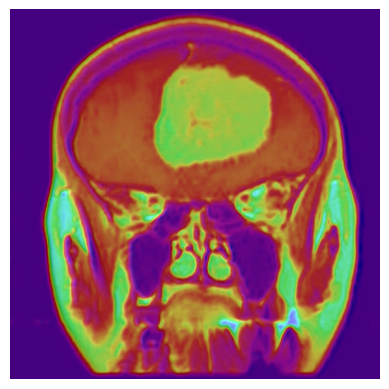

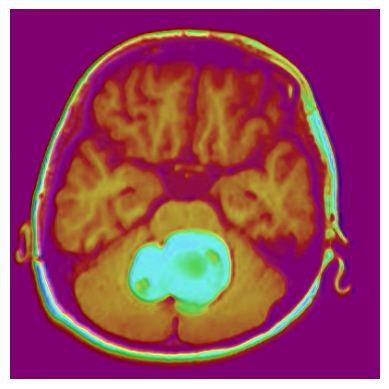

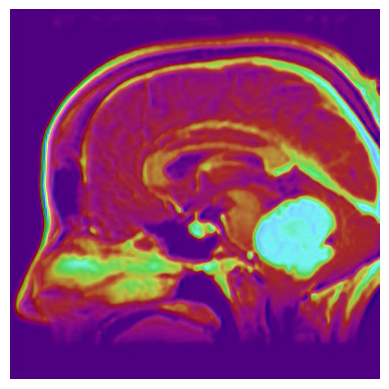

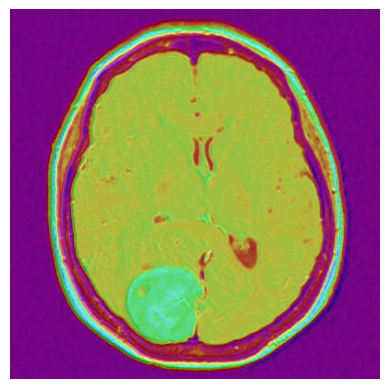

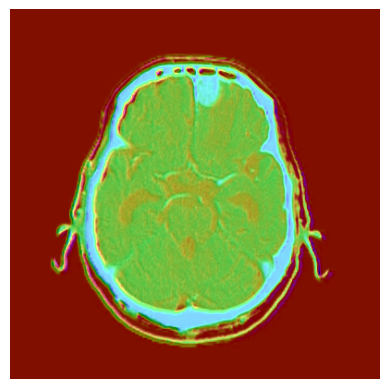

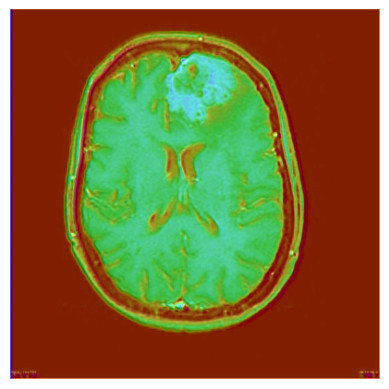

In [25]:
for imagem in range(21, 27):
    gradcam.faz_gradcam(path_da_imagem=f"../neuroscan/dados/Testing/meningioma_tumor/image({imagem}).jpg")